** Mohamed ALLILI & Sabrina CHAOUCHE **

Mohamed ALLILI & Sabrina CHAOUCHE

## Partie 1 - Description du problème

Étude de la fiabilité des sites de paris sportifs (côtes avant match)

## Partie 2 - Modèle

### Statistique déscreptive :
<ol>
<li>
Pour chaque site et pour chaque match, on récupère les côtes d’avant match. Selon la côte minimale on déduit le résultat probable et on le compare avec le résultat de fin du match.
</li>
<li>
Pour tous les sites et pour chaque match, on prend les côtes d’avant match. Pour chaque site on récupère la côte minimale et on déduit son résultat probable, puis on prend le résultat probable majoritaire parmi ceux de tous les sites et on le compare avec le résultat de fin de match.
</li>
</ol>
Dans les 2 cas, pour tous les matchs, on compte le nombre d’erreurs (erreur par match si on prend la côte minimale pour déduire le résultat du match) pour avoir à la fin un taux d’erreur.  $taux_{erreur} = \frac{nombre_{erreurs}}{nombre\_total_{matchs}}$.

## Partie 3 - Code

In [1]:
"""
Variables importantes :
    * data_player : données de la table player
    * data_playerattributes : données de la table playerattributes
    * data_team : données de la table team
    * data_teamattributes : données de la table teamattributes
    * data_match : données de la table match
    * data_country : données de la table country
    
    * countries : liste des pays
    * leagues : liste des ligues (championnats)
    ----> dans la table match il y a une seule ligue par pays
    * player_potentiel : le potentiel de chaque joueur (moyenne)
    * columns_cote : noms des colonnes correspondant aux sites de paris sportifs (home, draw, away)
    * columns_result_match : noms des colonnes colonnes dont on a besoin ( 'country_id', 'league_id', \ 
                                'season', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', \ 
                                'home_team_goal', 'away_team_goal' )
    * data_cotes : DataFrame de data_match avec les colonnes de columns_cote et columns_result_match
    * nom_sites : liste des noms des sites (sans 'H' ou 'D' ou 'A' à la fin)
    * liste_championnats : liste de DataFrames où chaque DataFrame contient uniquement les données d'un championnat
    
    * columns_player_home : nom des colonnes pour les IDs des joueurs home dans match
    * columns_player_away : nom des colonnes pour les IDs des joueurs away dans match
    * columns_team_match : nom des colonnes utiles à garder (équipes, buts, saison, date ...)
    * data_match_players : DataFrame de data_match avec les colonnes de columns_player_home, columns_player_away. \
                            En supprimant les lignes avec des valeurs nulles (car s'il manque un joueur le score de \
                            l'équipe qu'on calcule n'est pas fiable).
    * 
"""
print()

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
def moyenne(liste): 
    """calcul de la moyenne des valeurs de liste"""
    if (liste!= []): 
        return float(sum(liste)) / len(liste)
    else:
        return None

def moyenne_dict_val(dic):
    """calcul de la moyenne des valeurs du dictionnaire dic"""
    liste_tmp = list()
    for k,v in dic:
        liste_tmp.append(v)
    return moyenne(liste_tmp)


In [4]:
def get_match_season(data, season, _id=None):
    """
    data : ensemble de matchs
    season : une saison donnée (ex: 2008/2009)
    _id : id d'un pays
    ---> la fonction retourn tout les matchs de la saison 'season' si _id n'est pas donné \
            sinon les matchs de la saison 'season' du pays d'id=_id  
    """
    if _id != None:
        match_season = data.groupby("season").get_group(season)
        match_season_pays = match_season.groupby("country_id").get_group(_id)
        #on les trie
        match_season_pays = match_season_pays.sort_values(by=['date'], inplace=False)
        return match_season_pays
    else:        
        match_season = data.groupby("season").get_group(season)
        #on les trie
        match_season = match_season.sort_values(by=['date'], inplace=False)
        return match_season
    

In [5]:
def get_stat_site(nom, df):
    """
    nom : nom d'un site parmi ceux de la table match
    df : un ensemble de données (des matchs)
    --> la fonction retourne une liste 'liste_cote' où pour chaque ligne de df d'indice i, on lui associe à la ligne i \
                                        de 'liste_cote' 1 si les côtes avant match étaient fiables 
                                        -1 sinon
    """
    liste_cote = list()
    data = df[columns_result_match+[nom+'H', nom+'D', nom+'A']]
    data = data.dropna(inplace=False)
    lig, col = data.shape
    for i in range(lig):
        row = data.iloc[i]
        but1 = row['home_team_goal']
        but2 = row['away_team_goal']
        coteH = row[nom+'H']
        coteD = row[nom+'D']
        coteA = row[nom+'A']
        coteMin = min( min(coteH, coteD), coteA )
        if coteMin == coteH: # victoire equipe home
            if but1>but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        elif coteMin == coteD: # match nul
            if but1==but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        elif coteMin == coteA: # victoire equipe away
            if but1<but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        else:
            print("ERREUR : get_stat_site *** dans le code")
            return None
    #if len(liste_cote)==0:
    #     return -1
    return liste_cote

In [6]:
def get_stat_site_global(noms, df):
    """
    noms : ensemble de noms de sites de la table match
    df : un ensemble de données (des matchs)
    --> la fonction retourne une liste 'liste_cote' où pour chaque ligne de df d'indice i, on lui associe à la ligne i \
                                        de 'liste_cote' 1 si l'ensemble des côtes avant match étaient fiable c-à-d la \
                                        majorité des sites ont eu des côte avant match correspondant au résultat, \
                                        -1 sinon
    """
    data = df
    liste_cote = list()
    noms_h = []
    noms_d = []
    noms_a = []
    for nom in noms:
        noms_h.append(nom+'H')
        noms_d.append(nom+'D')
        noms_a.append(nom+'A')
    lig, col = data.shape
    for i in range(lig):
        row = data.iloc[i]
        but1 = row['home_team_goal']
        but2 = row['away_team_goal']
        coteH = 0
        coteD = 0
        coteA = 0
        for j in range(len(noms)):
            rowna = row.fillna(0)
            h = rowna[noms_h[j]]
            d = rowna[noms_d[j]]
            a = rowna[noms_a[j]]
            m = min(min(h,d), a)
            if m==h: coteH+=1
            elif m==d: coteD+=1
            elif m==a: coteA+=1
        resMax = max(max(coteH, coteD), coteA)
        if resMax == coteH: # victoire equipe home
            if but1>but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        elif resMax == coteD: # match nul
            if but1==but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        elif resMax == coteA: # victoire equipe away
            if but1<but2:
                liste_cote.append(1)
            else:
                liste_cote.append(-1)
        else:
            print("ERREUR : get_stat_site *** dans le code")
            return None
    return liste_cote

## Partie 4 - Protocole expérimental

In [7]:
data_player = pd.read_csv("soccer_csv/player.csv")
data_playerattributes = pd.read_csv("soccer_csv/playerattributes.csv")

In [8]:
data_playerattributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [9]:
data_team = pd.read_csv("soccer_csv/team.csv")
data_teamattributes = pd.read_csv("soccer_csv/teamattributes.csv")

In [10]:
data_teamattributes.groupby("buildUpPlaySpeedClass").count()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
buildUpPlaySpeedClass,,,,,,,,,,,,,,,,,,,,,
Balanced,1184,1184,1184,1184,1184,430,1184,1184,1184,1184,...,1184,1184,1184,1184,1184,1184,1184,1184,1184,1184
Fast,172,172,172,172,172,50,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
Slow,102,102,102,102,102,9,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102


In [11]:
data_match = pd.read_csv("soccer_csv/match.csv")

In [12]:
data_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [13]:
data_match.tail()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print("les colonnes de match")
for i in range(len(data_match.columns)):
    print(data_match.columns[i], end="', '")

les colonnes de match
id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_play

In [15]:
countries = data_match["country_id"].unique()
leagues = data_match["league_id"].unique()
print("country_id : ",countries)
print("league_id  : ", leagues)

country_id :  [    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]
league_id  :  [    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]


In [16]:
ind = 80
while ind < len(data_match.columns) :
    print(ind, " -> ", data_match.columns[ind])
    ind += 1

80  ->  foulcommit
81  ->  card
82  ->  cross
83  ->  corner
84  ->  possession
85  ->  B365H
86  ->  B365D
87  ->  B365A
88  ->  BWH
89  ->  BWD
90  ->  BWA
91  ->  IWH
92  ->  IWD
93  ->  IWA
94  ->  LBH
95  ->  LBD
96  ->  LBA
97  ->  PSH
98  ->  PSD
99  ->  PSA
100  ->  WHH
101  ->  WHD
102  ->  WHA
103  ->  SJH
104  ->  SJD
105  ->  SJA
106  ->  VCH
107  ->  VCD
108  ->  VCA
109  ->  GBH
110  ->  GBD
111  ->  GBA
112  ->  BSH
113  ->  BSD
114  ->  BSA


In [17]:
print("On récupère les colonnes correspondant aux sites de paris sportifs")
columns_cote = list()
ind = 85
i=0
while ind+i < len(data_match.columns) :
    columns_cote.append(data_match.columns[ind+i])
    i += 1

print(i)
columns_cote


On récupère les colonnes correspondant aux sites de paris sportifs
30


['B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'SJH',
 'SJD',
 'SJA',
 'VCH',
 'VCD',
 'VCA',
 'GBH',
 'GBD',
 'GBA',
 'BSH',
 'BSD',
 'BSA']

In [18]:
columns_result_match = ['country_id', 'league_id', 'season', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']
# On crée un DataFrame contenant  les cotes des paris sportifs
print("On crée un DataFrame contenant  les cotes des paris sportifs")
data_cotes = pd.DataFrame(data_match[columns_result_match+columns_cote])
data_cotes.count()

On crée un DataFrame contenant  les cotes des paris sportifs


country_id          25979
league_id           25979
season              25979
date                25979
match_api_id        25979
home_team_api_id    25979
away_team_api_id    25979
home_team_goal      25979
away_team_goal      25979
B365H               22592
B365D               22592
B365A               22592
BWH                 22575
BWD                 22575
BWA                 22575
IWH                 22520
IWD                 22520
IWA                 22520
LBH                 22556
LBD                 22556
LBA                 22556
PSH                 11168
PSD                 11168
PSA                 11168
WHH                 22571
WHD                 22571
WHA                 22571
SJH                 17097
SJD                 17097
SJA                 17097
VCH                 22568
VCD                 22568
VCA                 22568
GBH                 14162
GBD                 14162
GBA                 14162
BSH                 14161
BSD                 14161
BSA         

In [19]:
data_cotes.head()

,country_id,league_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,2008/2009,2008-08-17 00:00:00,492473,9987,9993,1,1,1.73,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,1,1,2008/2009,2008-08-16 00:00:00,492474,10000,9994,0,0,1.95,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,1,1,2008/2009,2008-08-16 00:00:00,492475,9984,8635,0,3,2.38,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,1,1,2008/2009,2008-08-17 00:00:00,492476,9991,9998,5,0,1.44,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,1,1,2008/2009,2008-08-16 00:00:00,492477,7947,9985,1,3,5.00,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [20]:
print("On récupère le nom de chaque site de paris sportifs")
nom_sites = list()
pas = 3
ind = 0 
while ind < len(columns_cote):
    #print(data_cotes[columns_cote[ind:ind+pas]].count())
    s = columns_cote[ind]
    s = s[0:len(s)-1]
    nom_sites.append(s)
    ind += 3
    
data_cotes[columns_cote[9:12]].dropna().count()
nom_sites

On récupère le nom de chaque site de paris sportifs


['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']

In [21]:
liste_stat_site = list()
for i in range(len(nom_sites)):
    res = get_stat_site(nom_sites[i], data_cotes)
    res = res.count(-1)*1.0/len(res)
    liste_stat_site.append(res)
    print("Taux d'erreur de ",nom_sites[i]," sur tous les matchs : ", res)

Taux d'erreur de  B365  sur tous les matchs :  0.46671388101983
Taux d'erreur de  BW  sur tous les matchs :  0.4684828349944629
Taux d'erreur de  IW  sur tous les matchs :  0.4683392539964476
Taux d'erreur de  LB  sur tous les matchs :  0.46856712183011173
Taux d'erreur de  PS  sur tous les matchs :  0.4728689111747851
Taux d'erreur de  WH  sur tous les matchs :  0.4685215542067254
Taux d'erreur de  SJ  sur tous les matchs :  0.466573082997017
Taux d'erreur de  VC  sur tous les matchs :  0.46712158808933
Taux d'erreur de  GB  sur tous les matchs :  0.4672362660641152
Taux d'erreur de  BS  sur tous les matchs :  0.46776357601864277


In [22]:
countries = data_match["country_id"].unique()
leagues = data_match["league_id"].unique()
print(countries)
print(leagues)
liste_championnats = list()
for i in range(len(countries)):
    liste_championnats.append( data_cotes.groupby("league_id").get_group(countries[i]) )

[    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]
[    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]


In [23]:
data_country = pd.read_csv("soccer_csv/country.csv")

In [24]:

liste_site_par_championnat = list()
for site in range(len(nom_sites)):
    liste_stat_site_par_championnat = list()
    liste_site_championnat = list()
    for i in range(len(countries)):
        res = get_stat_site(nom_sites[site], liste_championnats[i])
        #print(res)
        if len(res)==0 or res==None:
            continue
        res = res.count(-1)*1.0/len(res)
        liste_stat_site_par_championnat.append(res)
        liste_site_championnat.append(data_country.loc[ data_country["id"] == countries[i] ]["name"].iloc[0])
    liste_site_par_championnat.append((liste_site_championnat, liste_stat_site_par_championnat))


In [25]:
for i in range(len(liste_site_par_championnat)):
    pays = liste_site_par_championnat[i][0][0]
    stat = liste_site_par_championnat[i][1][0]
    print("stats de ",pays, " -> ", nom_sites[i], " : ", stat)

for i in range(len(liste_site_par_championnat)):
    pays = liste_site_par_championnat[i][0][1]
    stat = liste_site_par_championnat[i][1][1]
    print("stats de ",pays, " -> ", nom_sites[i], " : ", stat)

stats de  Belgium  ->  B365  :  0.4712778429073857
stats de  Belgium  ->  BW  :  0.47096774193548385
stats de  Belgium  ->  IW  :  0.47290930506478207
stats de  Belgium  ->  LB  :  0.4769775678866588
stats de  Belgium  ->  PS  :  0.4943661971830986
stats de  Belgium  ->  WH  :  0.47300469483568075
stats de  Belgium  ->  SJ  :  0.46957878315132606
stats de  Belgium  ->  VC  :  0.4730363423212192
stats de  Belgium  ->  GB  :  0.46890343698854337
stats de  Belgium  ->  BS  :  0.46551724137931033
stats de  England  ->  B365  :  0.4667763157894737
stats de  England  ->  BW  :  0.46692991115498517
stats de  England  ->  IW  :  0.46675444371296904
stats de  England  ->  LB  :  0.46725896676538337
stats de  England  ->  PS  :  0.46543778801843316
stats de  England  ->  WH  :  0.4680921052631579
stats de  England  ->  SJ  :  0.4625
stats de  England  ->  VC  :  0.4674342105263158
stats de  England  ->  GB  :  0.4697209057398631
stats de  England  ->  BS  :  0.4705263157894737


In [26]:
res = get_stat_site_global(nom_sites, liste_championnats[0])
print("Taux d'erreurs pour tous les championnats (arbitraire) : ", res.count(-1)/len(res))

Taux d'erreurs pour tous les championnats (arbitraire) :  0.47280092592592593


In [27]:
liste_tous_site_par_championnat = list()
liste_stat_tous_site_par_championnat = list()
liste_site_championnat = list()
for i in range(len(liste_championnats)):
    res = get_stat_site_global(nom_sites, liste_championnats[i])
    #print(res)
    if len(res)==0 or res==None:
        print("erreur: res==0 or res==null")
        continue
    res = res.count(-1)*1.0/len(res)
    liste_stat_tous_site_par_championnat.append(res)
    pays = data_country.loc[ data_country["id"] == countries[i] ]["name"].iloc[0]
    print("Taux d'erreur de tous les sites sur les matchs du pays", pays," : ", res)
    liste_site_championnat.append(pays)
liste_tous_site_par_championnat.append((liste_site_championnat, liste_stat_tous_site_par_championnat))


Taux d'erreur de tous les sites sur les matchs du pays Belgium  :  0.47280092592592593
Taux d'erreur de tous les sites sur les matchs du pays England  :  0.46875
Taux d'erreur de tous les sites sur les matchs du pays France  :  0.4921052631578947
Taux d'erreur de tous les sites sur les matchs du pays Germany  :  0.4861111111111111
Taux d'erreur de tous les sites sur les matchs du pays Italy  :  0.4666887636725224
Taux d'erreur de tous les sites sur les matchs du pays Netherlands  :  0.44607843137254904
Taux d'erreur de tous les sites sur les matchs du pays Poland  :  0.546875
Taux d'erreur de tous les sites sur les matchs du pays Portugal  :  0.452729044834308
Taux d'erreur de tous les sites sur les matchs du pays Scotland  :  0.49780701754385964
Taux d'erreur de tous les sites sur les matchs du pays Spain  :  0.4394736842105263
Taux d'erreur de tous les sites sur les matchs du pays Switzerland  :  0.5428973277074542


In [28]:
liste_site_championnat

['Belgium',
 'England',
 'France',
 'Germany',
 'Italy',
 'Netherlands',
 'Poland',
 'Portugal',
 'Scotland',
 'Spain',
 'Switzerland']

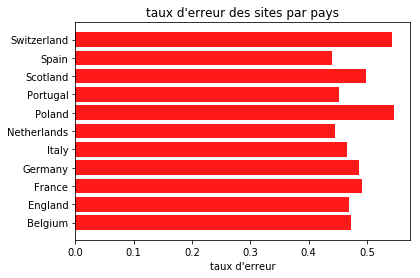

In [29]:
pays = liste_tous_site_par_championnat[0][0]
stat = liste_tous_site_par_championnat[0][1]
y_pos = list(range(len(pays)))
plt.barh(y_pos, stat, align='center', color="red", alpha=0.9)
plt.yticks(y_pos, pays)
plt.xlabel("taux d'erreur")
plt.title("taux d'erreur des sites par pays")
plt.figure()
plt.show()

## Partie 5 - Résultats

### Taux d'erreurs par site sur tous les matchs

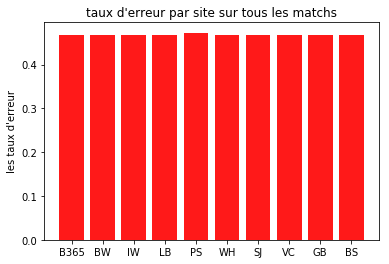

taux d'erreurs moyen :  0.46821880703914687


In [30]:
y_pos = list(range(len(nom_sites)))
plt.bar(y_pos, liste_stat_site, align='center', color="red", alpha=0.9)
plt.xticks(y_pos, nom_sites)
plt.ylabel("les taux d'erreur")
plt.title("taux d'erreur par site sur tous les matchs")
plt.show()
print("taux d'erreurs moyen : ", moyenne(liste_stat_site))

### Taux d'erreur de chaque site pour chaque pays

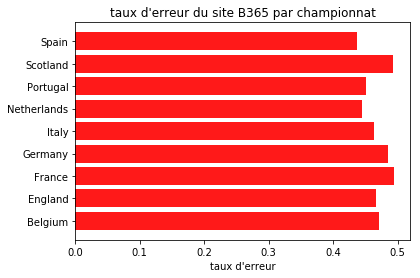

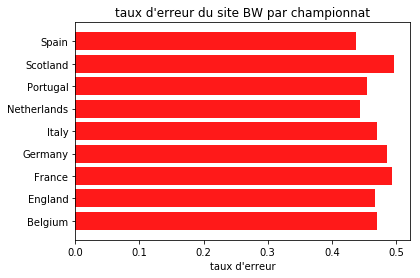

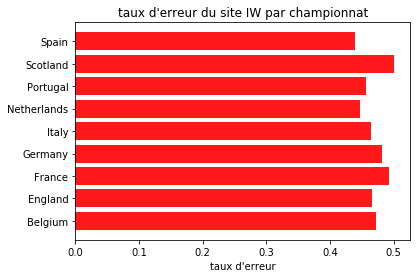

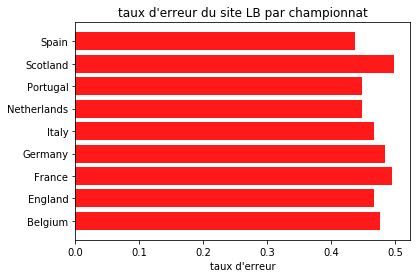

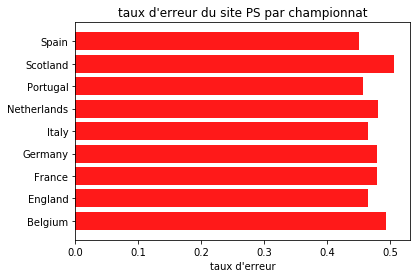

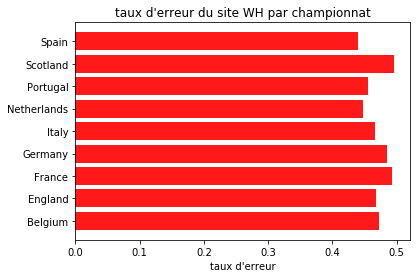

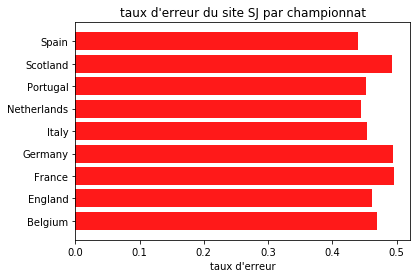

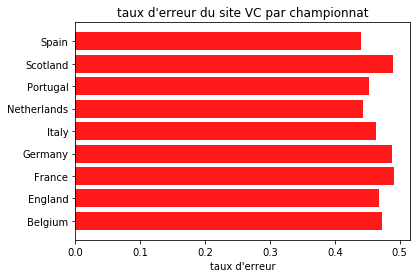

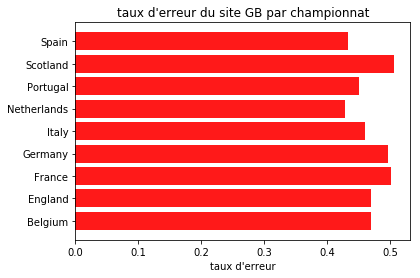

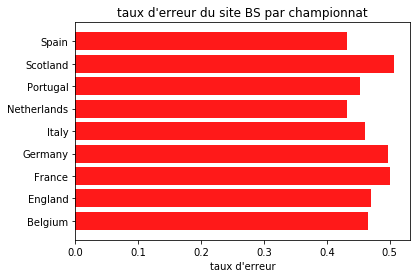

In [31]:
for i in range(len(liste_site_par_championnat)):
    pays = liste_site_par_championnat[i][0]
    stat = liste_site_par_championnat[i][1]
    y_pos = list(range(len(pays)))
    plt.barh(y_pos, stat, align='center', color="red", alpha=0.9)
    plt.yticks(y_pos, pays)
    plt.xlabel("taux d'erreur")
    plt.title("taux d'erreur du site "+nom_sites[i]+" par championnat")
    plt.figure()
    plt.show()


### Taux d'erreurs de tous les sites pour chaque pays

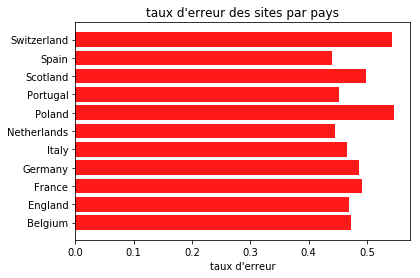

taux d'erreurs moyen :  0.48293786995783194


In [32]:
pays = liste_tous_site_par_championnat[0][0]
stat = liste_tous_site_par_championnat[0][1]
y_pos = list(range(len(pays)))
plt.barh(y_pos, stat, align='center', color="red", alpha=0.9)
plt.yticks(y_pos, pays)
plt.xlabel("taux d'erreur")
plt.title("taux d'erreur des sites par pays")
plt.figure()
plt.show()
print("taux d'erreurs moyen : ", moyenne(liste_tous_site_par_championnat[0][1]))

## Partie 6 - Analyse

On a eu comme résultats:
* Taux d'erreurs moyen par site sur tous les match : 46.8%
* Taux d'erreurs de tous les sites pour chaque pays : 48.29%
* La variance du taux d'erreurs de chaque site par pays est faible, la moyenne est toujours proche de 48.29% (taux d'erreurs de tous les sites pour chaque pays)

A partir de ces résultats, on coclut que les côtes d'avant match des sites de paris sportifs <b>ne sont pas fiables</b> pour essayer de prédir le résultat d'un match (match nul, victoire home, victoire away) et ça explique pourquoi ce genre de sites sont toujours gagnants.<br>
Sinon, si les côtes étaient fiables (<b>un taux d'erreurs ~ faible</b>) on aurait pu construire un modèle prédictif qui se base dessus.